In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../../')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

cpu


In [6]:
import numpy as np

In [4]:
data_dir = '../data/data_preprocessed/heartsound/preprocessing/'

In [7]:
data_x = np.load(f'{data_dir}heartsound.audio2k.validation.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}heartsound.label_binary.validation.npy', allow_pickle=True)

In [8]:
test_set = list(zip(data_x, data_y))

In [9]:
sr = 2000

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=30, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 2

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [10]:
from omegaconf import OmegaConf as ocf

model_dir = '../models_heartsound/'
model_config_path = model_dir + 'm21.yaml'
model_config = ocf.load(model_config_path)
model_config

{'config': {'name': 'M21', 'description': 'FirConv for heart sound classification', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [4], 'window_k': [2], 'residual_connection_type': 'stack', 'pooling': 'max', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 4, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [312, 312], 'norm_type': 'LayerNorm'}}, 'n_input': 1, 'n_output': 2, 'train_config': {'name': 'torch 12g', 'batch_size': 2, 'early_stopping': True, 'accumulate_grad': True, 'accumulate_grad_scheduler': {0: 16, 40: 8, 60: 16, 5: 8, 9: 16, 16: 8, 30: 16, 80: 8}, 'checkpoint_save_top_k': 5, 'optimizer': 'RAdam', 'optimizer_kwargs': {'weight_decay': 0.0001}, 'learning_rate_init': 0.001, 'lr_scheduler': 'OneCyleLR', 'lr_scheduler_kwargs': {'step_size': 40}, 'max_epochs': 500, 'min_epochs': 80, 'detect_anomaly': False, 'accele

In [11]:
from IConNet.nn.model import M21

In [14]:
model = M21(config=model_config.config,
           n_input=1, n_output=2)
model

M21(
  (downsample): Resample()
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): LongConv1d(
              (pad_layer): PadRight()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): LongConv1d(
            (pad_layer): PadRight()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
      

In [15]:
test_loader_length = len(test_loader.dataset)

In [16]:
model_ckpt = 'M21.epoch=75-val_UA=0.88-val_UF1=0.87-val_WF1=0.90.ckpt'
state_dict = torch.load(model_dir + model_ckpt)
state_dict

{'epoch': 75,
 'global_step': 44421,
 'pytorch-lightning_version': '2.2.0.post0',
 'state_dict': OrderedDict([('model.downsample.kernel',
               tensor([[[-0.0000e+00, -3.0658e-07, -8.5466e-06, -3.6812e-05, -8.7696e-05,
                         -1.4940e-04, -1.9577e-04, -1.9165e-04, -1.0279e-04,  9.1722e-05,
                          3.8766e-04,  7.4801e-04,  1.1025e-03,  1.3557e-03,  1.4047e-03,
                          1.1616e-03,  5.8016e-04, -3.2305e-04, -1.4551e-03, -2.6478e-03,
                         -3.6753e-03, -4.2878e-03, -4.2566e-03, -3.4256e-03, -1.7573e-03,
                          6.3388e-04,  3.4724e-03,  6.3395e-03,  8.7221e-03,  1.0087e-02,
                          9.9702e-03,  8.0756e-03,  4.3534e-03, -9.4253e-04, -7.2407e-03,
                         -1.3685e-02, -1.9214e-02, -2.2689e-02, -2.3039e-02, -1.9417e-02,
                         -1.1349e-02,  1.1677e-03,  1.7612e-02,  3.6954e-02,  5.7741e-02,
                          7.8239e-02,  9.6623e-02,  

In [19]:
state_dict['state_dict'].keys()

odict_keys(['model.downsample.kernel', 'model.fe_blocks.blocks.0.block.layer.window_params', 'model.fe_blocks.blocks.0.block.layer.lowcut_bands', 'model.fe_blocks.blocks.0.block.layer.bandwidths', 'model.fe_blocks.blocks.0.block.layer.filter_time', 'model.cls_head.blocks.0.norm.weight', 'model.cls_head.blocks.0.norm.bias', 'model.cls_head.blocks.0.layer.weight', 'model.cls_head.blocks.0.layer.bias', 'model.cls_head.blocks.1.norm.weight', 'model.cls_head.blocks.1.norm.bias', 'model.cls_head.blocks.1.layer.weight', 'model.cls_head.blocks.1.layer.bias', 'model.cls_head.output_layer.weight', 'model.cls_head.output_layer.bias'])

In [20]:
from collections import OrderedDict

In [21]:
d = OrderedDict()

In [22]:
for k,v in state_dict['state_dict'].items():
    key = k.replace('model.', '')
    d[key] = v

In [23]:
model.load_state_dict(d)

<All keys matched successfully>

In [27]:
layer.window_params

Parameter containing:
tensor([ 3.3404, -0.1748], requires_grad=True)

In [24]:
layer = model.fe_blocks.blocks[0].block.layer

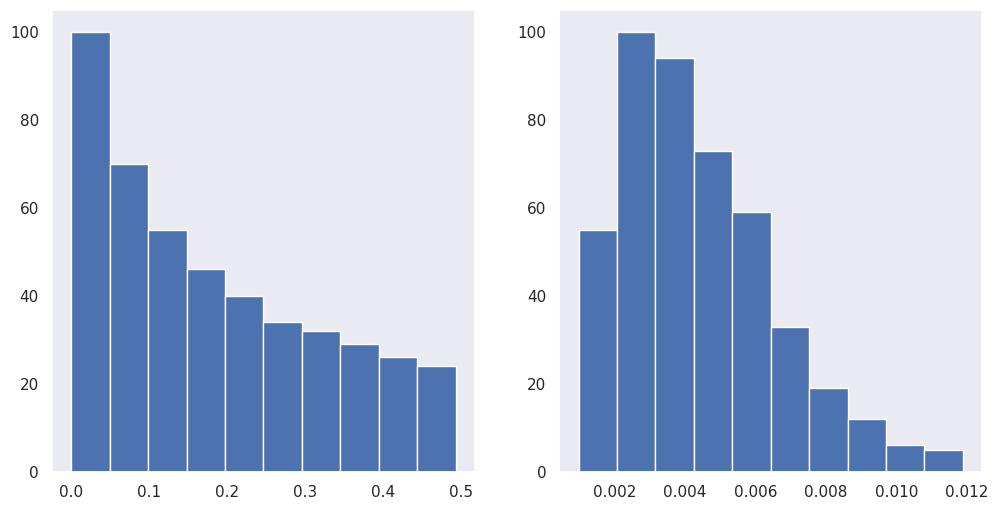

In [25]:
from IConNet.visualizer import visualize_model
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [26]:
filtviz.visualize_filters(filter_domain='time')

EinopsError:  Error while processing rearrange-reduction pattern "h c p -> (h c) p".
 Input tensor shape: (2,). Additional info: {}.
 Wrong shape: expected 3 dims. Received 1-dim tensor.

In [ ]:
@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc